http://openaccess.thecvf.com/content_CVPR_2019/papers/Chen_Self-Supervised_GANs_via_Auxiliary_Rotation_Loss_CVPR_2019_paper.pdf




## Setup

In [1]:
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
keras.backend.clear_session()
tf.__version__

'2.2.0-rc4'

## WGAN

the discriminator is trained to detect rotation angles based only on the true data. In other words, the parameters of the discriminator get updated only based on the rotation loss on the true data.

In [0]:
class WGAN(keras.Model):
  def __init__(self, discriminator, generator, latent_dim, disc_rot_param = 1.0, gen_rot_param = 0.2):
    super(WGAN, self).__init__()
    self.discriminator = discriminator
    self.generator = generator
    self.latent_dim = latent_dim
    self.disc_rot_param = disc_rot_param
    self.gen_rot_param = gen_rot_param

  def compile(self, d_optimizer, g_optimizer):
    super(WGAN, self).compile()
    self.d_optimizer = d_optimizer
    self.g_optimizer = g_optimizer

  def rotate_(self, images, batch_size):
    #Apply rotations to the images
    images1 = images # rotation = 0
    images2 = tf.image.rot90(images, k = 1)#rotation=90
    images3 = tf.image.rot90(images, k = 2)#rotation=180
    images4 = tf.image.rot90(images, k = 3)#rotation=270

    images_all = tf.concat([images1, images2, images3, images4], axis=0)

    images_all_label = tf.repeat(np.arange(4, dtype=np.int32), batch_size)

    return images_all, images_all_label

  def rot_acc(self, logits, y):
    preds = keras.activations.softmax(logits, axis=-1)
    return tf.reduce_mean(tf.cast(tf.equal(tf.cast(tf.argmax(preds, 1), tf.int32), y),
                                      tf.float32))

  def generate(self,z): 
    return self.generator(z)

  def discriminate(self,imgs):
    return self.discriminator(imgs)

  def train_step(self, real_images):
    batch_size = tf.shape(real_images)[0]

    #Train Critic 1 times
    for _ in range(1):
      with tf.GradientTape() as disc_tape:
        random_latent_vectors = tf.random.uniform(shape=(batch_size, self.latent_dim), minval=0.0, maxval=0.99)

        # Decode them to fake images
        generated_images = self.generate(random_latent_vectors)

        # Rotated images and labels
        rotated_real_imgs, rotated_real_labels= self.rotate_(real_images, batch_size)

        # Get the outputs for real and fake images
        disc_real, _ = self.discriminate(real_images)
        disc_fake, _ = self.discriminate(generated_images)

        # Get the rotation outputs for real and fake images 
        _, disc_rot = self.discriminate(rotated_real_imgs)

        # Get the loss going
        disc_rot_acc = self.rot_acc(disc_rot, rotated_real_labels)

        disc_rot_loss =  tf.reduce_mean(tf.keras.losses.categorical_crossentropy( #Rotation loss for the discriminator
                                    tf.one_hot(rotated_real_labels, 4),
                                    disc_rot, from_logits=True))
        
        disc_loss = - tf.reduce_mean(disc_real) + tf.reduce_mean(disc_fake)
        disc_loss += self.disc_rot_param * disc_rot_loss

      # Train the discriminator
      d_grads = disc_tape.gradient(disc_loss, self.discriminator.trainable_weights)
      self.d_optimizer.apply_gradients(zip(d_grads, self.discriminator.trainable_weights))

    # Train the generator 1 time
    with tf.GradientTape() as gen_tape:
      random_latent_vectors = tf.random.uniform(shape=(batch_size, self.latent_dim), minval=0.0, maxval=0.99)

      # Decode them to fake images
      generated_images = self.generate(random_latent_vectors)

      # Rotated images and labels
      rotated_fakes_imgs, rotated_fakes_labels= self.rotate_(generated_images, batch_size)

      # Get the rotation outputs for real and fake images 
      _, gen_rot = self.discriminate(rotated_fakes_imgs)
      
      # Get the outputs for fake images
      disc_fake, _ = self.discriminate(generated_images)        

      # Get the loss going
      gen_rot_acc = self.rot_acc(gen_rot, rotated_fakes_labels)

      gen_rot_loss =  tf.reduce_mean(keras.losses.categorical_crossentropy( #Rotation loss for the generator
                                     tf.one_hot(rotated_fakes_labels, 4),
                                     gen_rot, from_logits=True))
      gen_loss = - tf.reduce_mean(disc_fake) + self.gen_rot_param * gen_rot_loss

    g_grads = gen_tape.gradient(gen_loss, self.generator.trainable_weights)
    self.g_optimizer.apply_gradients(zip(g_grads, self.generator.trainable_weights))

    return {'d_loss': disc_loss, 'g_loss': gen_loss, 'd_rot_acc': disc_rot_acc, 'g_rot_acc': gen_rot_acc}

In [0]:
TRAIN_BUF=60000
BATCH_SIZE=32
TEST_BUF=10000
DIMS = (28,28,1)
latent_dim = 64
N_TRAIN_BATCHES =int(TRAIN_BUF/BATCH_SIZE)
N_TEST_BATCHES = int(TEST_BUF/BATCH_SIZE)

In [0]:
# spectral norm from https://colab.research.google.com/drive/1f2Ejlm3UmsthqQni9vFkGmTTcS_ndqXR#scrollTo=vQ0QgmWmOE64

from tensorflow.keras.constraints import Constraint

def l2_normalize(x, eps=1e-12):
  '''
  Scale input by the inverse of it's euclidean norm
  '''
  return x / tf.linalg.norm(x + eps)

class Spectral_Norm(Constraint):
    '''
    Uses power iteration method to calculate a fast approximation 
    of the spectral norm (Golub & Van der Vorst)
    The weights are then scaled by the inverse of the spectral norm
    '''
    def __init__(self, power_iters=POWER_ITERATIONS):
        self.n_iters = power_iters

    def __call__(self, w):
      flattened_w = tf.reshape(w, [w.shape[0], -1])
      u = tf.random.normal([flattened_w.shape[0]])
      v = tf.random.normal([flattened_w.shape[1]])
      for i in range(self.n_iters):
        v = tf.linalg.matvec(tf.transpose(flattened_w), u)
        v = l2_normalize(v)
        u = tf.linalg.matvec(flattened_w, v)
        u = l2_normalize(u)
      sigma = tf.tensordot(u, tf.linalg.matvec(flattened_w, v), axes=1)
      return w / sigma

    def get_config(self):
        return {'n_iters': self.n_iters}

In [0]:
# Create the discriminator
def discriminator_model():
  inp = keras.Input(shape=DIMS, name = "disc_input")
  netw = layers.Conv2D(32, (3, 3), strides=(1, 1), kernel_constraint=Spectral_Norm(),
                padding='same')(inp)
  netw = layers.LeakyReLU(alpha=0.2)(netw)
  netw = layers.Conv2D(64, (4, 4), strides=(2, 2), kernel_constraint=Spectral_Norm(),
                padding='same')(netw)
  netw = layers.LeakyReLU(alpha=0.2)(netw)
  netw = layers.Conv2D(128, (3, 3), strides=(1, 1), kernel_constraint=Spectral_Norm(),
                padding='same')(netw)
  netw = layers.LeakyReLU(alpha=0.2)(netw)

  net_disc = layers.GlobalMaxPooling2D()(netw)
  net_disc = layers.Dense(units=1, kernel_constraint=Spectral_Norm())(net_disc)

  net_ss = layers.Flatten()(netw)
  net_ss = layers.Dense(units=4, kernel_constraint=Spectral_Norm())(net_ss)

  model = tf.keras.Model(inputs=inp, outputs=[net_disc,net_ss])
  return model

w_critic = discriminator_model()

# Create the generator
def generator_model():
  inp = keras.Input(shape=(latent_dim,), name="gen_input")
  # We want to generate 64 coefficients to reshape into a 64 map
  netw = layers.Dense(7 * 7 * latent_dim)(inp)
  netw = layers.ReLU()(netw)
  netw = layers.Reshape((7, 7, latent_dim))(netw)
  netw = layers.Conv2DTranspose(latent_dim * 2, (3, 3), strides=(2, 2), padding='same')(netw)
  netw = layers.ReLU()(netw)
  netw = layers.Conv2DTranspose(latent_dim * 4, (3, 3), strides=(2, 2), padding='same')(netw)
  netw = layers.ReLU()(netw)
  netw = layers.Conv2DTranspose(latent_dim * 8, (4, 4), strides=(2, 2), padding='same')(netw)
  netw = layers.ReLU()(netw)
  netw = layers.Conv2D(1, (3, 3), strides=(2, 2), padding='same', activation='sigmoid')(netw)
  model = tf.keras.Model(inputs=inp, outputs=netw)
  return model

generator = generator_model()

In [11]:
# load dataset
(train_images, _), (test_images, _) = tf.keras.datasets.fashion_mnist.load_data()

# split dataset
train_images = np.reshape(train_images,(-1, 28, 28, 1)).astype(
    "float32"
) / 255.0
test_images = np.reshape(test_images,(-1, 28, 28, 1)).astype("float32") / 255.0

# batch datasets
train_dataset = (
    tf.data.Dataset.from_tensor_slices(train_images)
    .shuffle(TRAIN_BUF)
    .batch(BATCH_SIZE)
)
test_dataset = (
    tf.data.Dataset.from_tensor_slices(test_images)
    .shuffle(TEST_BUF)
    .batch(BATCH_SIZE)
)

4423680/4422102 [==============================] - 0s 0us/step


In [0]:
gen_optimizer = keras.optimizers.Adam(0.0002, beta_1=0.5)
disc_optimizer = keras.optimizers.Adam(0.0001)
# model
model = WGAN(
    generator = generator,
    discriminator = w_critic,
    latent_dim = latent_dim,
)

model.compile(
    d_optimizer=disc_optimizer,
    g_optimizer=gen_optimizer,
)

In [13]:
hist = model.fit(train_dataset, epochs=20)

Epoch 1/20
1875/1875 [==============================] - 862s 460ms/step - d_loss: 0.5778 - g_loss: -0.2299 - d_rot_acc: 0.8037 - g_rot_acc: 0.9704
Epoch 2/20
1875/1875 [==============================] - 858s 458ms/step - d_loss: 0.4499 - g_loss: -0.0390 - d_rot_acc: 0.8501 - g_rot_acc: 0.9721
Epoch 3/20
1875/1875 [==============================] - 864s 461ms/step - d_loss: 0.2984 - g_loss: 0.3902 - d_rot_acc: 0.8496 - g_rot_acc: 0.9833
Epoch 4/20
1875/1875 [==============================] - 861s 459ms/step - d_loss: -1.3378 - g_loss: 1.2421 - d_rot_acc: 0.8390 - g_rot_acc: 0.9800
Epoch 5/20
1875/1875 [==============================] - 860s 459ms/step - d_loss: -4.8154 - g_loss: 1.4053 - d_rot_acc: 0.8289 - g_rot_acc: 0.7175
Epoch 6/20
1875/1875 [==============================] - 856s 457ms/step - d_loss: -22.2828 - g_loss: -3.0212 - d_rot_acc: 0.8560 - g_rot_acc: 0.2500
Epoch 7/20
1875/1875 [==============================] - 861s 459ms/step - d_loss: -4.5067 - g_loss: 18.1564 - d_rot_a

KeyboardInterrupt: ignored

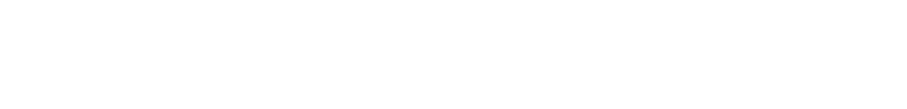

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

# exampled data for plotting results
def plot_reconstruction(model, nex=8, zm=2):
    samples = model.predict(tf.random.uniform(shape=(BATCH_SIZE, latent_dim), minval=0.0, maxval=0.99))
    fig, axs = plt.subplots(ncols=nex, nrows=1, figsize=(zm * nex, zm))
    for axi in range(nex):
        axs[axi].matshow(
                    samples[axi].squeeze(), cmap=plt.cm.Greys, vmin=0, vmax=1
                )
        axs[axi].axis('off')
    plt.show()

plot_reconstruction(generator)

In [20]:
# Get training and test loss histories
d_loss = hist.history['d_loss']
g_loss = hist.history['g_loss']
# Create count of the number of epochs
epoch_count = range(1, len(d_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, d_loss, 'r--')
plt.plot(epoch_count, g_loss, 'b-')

plt.legend(['Critic Loss', 'Generator Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

NameError: ignored